True
My program took 0.0322871208190918 to run


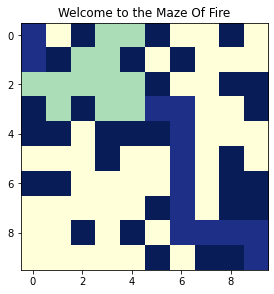

In [4]:
import matplotlib.pyplot as plt
from collections import deque
import random
import time
from queue import PriorityQueue
import numpy as np
from numpy.linalg import norm
import copy
import sys

start_time = time.time()

dim = 10  #Dimensions of the maze
p = 0.3 #Probability of cell being occupied

PATH_VALUE = 0.9
OBSTACLE_VALUE = 1
FIRE_VALUE = 0.3
START_AND_END_POINT_VALUE = 0.2
BFS_VISITED_VALUE = 0.5

Q_PROBABILITY_VALUE = 0.2 # probability of fire spreading

#Initializes the maze with randomized values


class Node:
    # (x, y) represents coordinates of a cell in matrix
    # maintain a parent node for printing path
    def __init__(self, x, y, parent):
        self.x = x # x coordinate
        self.y = y # y coordinate
        self.parent = parent # the parent coordinate of the current coordinate

    def __repr__(self):
        return str((self.x, self.y)) # used to print 

#Generating Maze by inputting values randomly
def maze_generator(dim, p):
    maze = []
    for i in range(dim):
        maze.append([])
        for j in range(dim):
            value = random.random() <= p # can either be 0 or 1
            maze[i].append(value)
    maze[0][0] = START_AND_END_POINT_VALUE #Start Point
    maze[-1][-1] = START_AND_END_POINT_VALUE # End Point
    return maze

maze = maze_generator(dim,p)

def generate_fire(q, maze):
    temp = maze[:]
    fire = 0
    # go throughout the entire maze and check if there are coordinates on fire
    for row in range(dim):
        for col in range(dim):
            # a coordinate can become on fire only if it is not an obstacle or not already on fire
            if maze[row][col] != FIRE_VALUE and maze[row][col] != OBSTACLE_VALUE:
                # find all the children of this coordinate that are on fire
                k = generate_fire_children(row, col)
                
                prob = 1 - pow((1-q), k)
                
                check = random.random() <= prob
                # set the coordinate on fire if true
                if check == True:
                    fire = fire+1
                    temp[row][col] = FIRE_VALUE
    return temp

def generate_fire_children(i, j):
    k = 0
    row_direction = [-1, 1, 0, 0] #(north, south, east, west) {check the row above, check the row below, 0, 0}
    col_direction = [0, 0, 1, -1] # {0, 0, Check the column to the right, check the column to the left}
    for d in range(0,4): # loop through every possible coordinate
        row = i + row_direction[d]
        col = j + col_direction[d]

        if row in range(0, dim): # check if the row coordinate is out of bounds
            if(col in range(0,dim)): # check if the col coordinate is out of bounds
                if(maze[row][col] == FIRE_VALUE): # Check if the (row, col) coordinate is on fire
                    k = k+1
    return k

def initialize_fire(maze):
    maze[0][0] = 0.2 #Start Point
    maze[-1][-1] = 0.2 # End Point
    while True: # generate random starting point for the fire
        row = random.randint(0,dim-1) # generate random row coordinate 
        col = random.randint(0,dim-1) # generate random col coordinate
        if maze[row][col] != OBSTACLE_VALUE and maze[row][col] != START_AND_END_POINT_VALUE: # do not generate fire if it is an obstacle or a start or goal state
            maze[row][col] = FIRE_VALUE
            break
    return maze

def strategy_one(node, maze):
    
    # end the recursion once all the nodes have been visited
    if node is None:
        return 0

    # recurse through node and generate a path
    length = strategy_one(node.parent, maze)
    
    # spread the fire for each path generated
    maze = generate_fire(Q_PROBABILITY_VALUE, maze)
    # if there are any points in the path that are already on fire, abort.
    if maze[node.x][node.y] == FIRE_VALUE:
        print("We have hit the fire. Abort")
        sys.exit(0)
    # mark the path as visited
    maze[node.x][node.y] = PATH_VALUE
    
    
    return length


def bfs_search_regular(start, goal, maze):
    # copy the maze so that the path can be maintianed
    tempMaze = copy.deepcopy(maze)
    # initialize fringe queue and closed set array
    fringe = deque()
    closed_set = []
    # initialize the first coordinate and append it to the fringe
    src = Node(start[0], start[1], None)
    fringe.append(src)

    while fringe:
        current = fringe.popleft()
        
        # there is a path for this maze
        if (current.x, current.y) == goal:
            # Initialize the point where the fire will be in the maze
            maze = initialize_fire(maze)
            strategy_one(current, maze)
            return True
        else:
            # check if current has already been visited
            if tempMaze[current.x][current.y] != BFS_VISITED_VALUE:
                generate_valid_children_B_regular(current, fringe, tempMaze)
                # mark the coordinate as visited
                tempMaze[current.x][current.y] = BFS_VISITED_VALUE
                closed_set.append(current)
    return False

def generate_valid_children_B_regular(current, fringe, tempMaze):
    row_direction = [-1, 1, 0, 0] #(north, south, east, west) {check the row above, check the row below, 0, 0}
    col_direction = [0, 0, 1, -1]# {0, 0, Check the column to the right, check the column to the left}

    # loop through every possible coordinate
    for i in range(0,4):
        row = current.x + row_direction[i]
        col = current.y + col_direction[i]

        # if the row coordinate is out of bounds, it cannot be added to the fringe
        if row in range(0, dim):
            # if the col coordinate is out of bounds, it cannot be added to the fringe
            if(col in range(0,dim)):
                # Check if the (row, col) coordinate is a obstacle
                if(tempMaze[row][col] != OBSTACLE_VALUE):
                    # Add to the fringe if it is a valid coordinate and not an obstacle
                    if(tempMaze[row][col] != BFS_VISITED_VALUE):
                        # Check if the coordinates are already visited
                        fringe.append(Node(row, col, current))
                        

start = (0,0)
goal = (dim-1, dim-1)
print(bfs_search_regular(start, goal, maze))

#creating the size of the figure as well as the size of each individual square in the grid
Grid = plt.figure(figsize=(dim,dim)).add_subplot(224) 
Grid.set_title('Welcome to the Maze Of Fire')

#Display the data as an image
Image = plt.imshow(maze)

#Colormap of the generated grid ranging from yellow to blue
#Yellow equals free space (0)
#Dark Blue equals unavailable Space(1)
Image.set_cmap('YlGnBu')

print("My program took", time.time() - start_time, "to run")